In [55]:
from time import perf_counter
import numpy as np  
import matplotlib.pyplot as plt

"""Performs Semi-Grand Monte Carlo (SGMC) reconstruction of Cu surface.
Produces a temperature/structure map
"""

import os
import sys
sys.path.append("/home/dux/")

import matplotlib.pyplot as plt
import numpy as np

# from labutil.src.plugins.lammps import (lammps_run, get_lammps_energy)
# from labutil.src.objects import (ClassicalPotential, Struc, ase2struc, Dir)
from ase.spacegroup import crystal
from ase.build import make_supercell, bulk
from ase.io import write
import ase
import catkit
from catkit.gen.adsorption import get_adsorption_sites
import random

from ase.calculators.eam import EAM

def initialize_slab(alat, elem='Cu', vacuum=15.0):
    """Creates the slab structure using ASE.

    Parameters
    ----------
    alat : float
        Lattice parameter in angstroms
    """

    # slab = fcc100(elem, size=(4,4,4), a=alat, vacuum=vacuum)


    # TODO: adjust size of surface if necessary
    a1 = bulk(elem, 'fcc', a=alat)
    catkit_slab = catkit.build.surface(a1, size=(4,4,4), miller=(1,0,0), termination=0, fixed=0, vacuum=vacuum, orthogonal=False)

    write('catkit_slab.cif', catkit_slab)
    return catkit_slab

def get_random_idx(connectivity, type=None):
    """Get random site index
    """
    connectivities = {
        'top': 1,
        'bridge': 2,
        'hollow': 4
    } # defaults to hollow

    # top should have connectivity 1, bridge should be 2 and hollow more like 4

    if type:
        # TODO: implemente preferred connecitivity
        pass
    
    site_idx = random.randrange(len(connectivity))

    return site_idx

'''
Code block to calculate energy of the slab
'''
def slab_energy(slab):
    """Calculate slab energy.
    Probably will have to call external lib
    """
    potential = EAM(potential='Cu2.eam.fs')
    
    slab.calc = potential
    energy = slab.get_potential_energy()
    return energy

def spin_flip(state, slab, temp, pot, prev_energy=None, save_cif=False, iter=1, site_idx=None, testing=False):
    """Based on the Ising model, models the adsorption/desorption of atoms from surface lattice sites

    Parameters
    ----------
    state : np.array
        dimension the number of sites
    slab : catkit.gratoms.Gratoms
        model of the surface slab
    temp : float
        temperature
    pot : float
        chemical potential of metal (Cu)

    Returns
    -------
    np.array, float
        new state, energy change
    """

    # choose a site to flip, 
    coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)

    if not site_idx:
        site_idx = get_random_idx(connectivity)
    rand_site = coords[site_idx]

    print(f"idx is {site_idx} at {rand_site} with connectivity {connectivity[site_idx]}")

    # determine if site vacant or filled
    filled = (state > 0)[site_idx]
    proposed_state = state.copy()
    print(f"before proposed state is")
    print(proposed_state)


    # change in number of adsorbates (Cu atoms)
    delta_N = 0

    # case site is vacant (spin down)
    if not filled:
        delta_N = 1 # add one Cu atom
        print("site is not filled, attempting to adsorb")
        print(f"current slab has {len(slab)} atoms")
        Cu = catkit.gratoms.Gratoms('Cu')
        # tag the atom to be adsorbed with its to-be index (last position on slab)    
        adsorbate_idx = len(slab)
        # Cu.set_tags(adsorbate_idx)
        proposed_state[site_idx] = adsorbate_idx
        proposed_slab_builder = catkit.gen.adsorption.Builder(slab)
        proposed_slab = proposed_slab_builder.add_adsorbate(Cu, bonds=[0], index=site_idx, auto_construct=False, symmetric=False)
        print(f"proposed slab has {len(proposed_slab)} atoms")

    # case site is filled (spin up)
    else:
        delta_N = -1 # remove one Cu atom
        print("site is filled, attempting to desorb")
        print(f"current slab has {len(slab)} atoms")
        adsorbate_idx = state[site_idx]
        # slab_tags = slab.get_tags()

        assert len(np.argwhere(state==adsorbate_idx)) <= 1, "more than 1 site found"
        assert len(np.argwhere(state==adsorbate_idx)) == 1, "no sites found"
        # np.argwhere(state==adsorbate_idx)[0,0]

        # import pdb;pdb.set_trace()

        proposed_slab = slab.copy()
        # import pdb;pdb.set_trace()
        del proposed_slab[int(adsorbate_idx)] #networkxx needs python int 
        # import pdb;pdb.set_trace()

        # lower the index
        proposed_state = np.where(state>0, state-1, 0)
        # remove the adsorbate from tracking
        proposed_state[site_idx] = 0

        print(f"proposed slab has {len(proposed_slab)} atoms")
    
    print(f"after proposed state is")
    print(proposed_state)

    if save_cif:
        write(f'proposed_slab_iter_{iter:03}.cif', proposed_slab)

    # to test, always accept
    if testing:
        slab = proposed_slab.copy()
        state = proposed_state.copy()
        energy = 0
    else:
        if not prev_energy:
            # calculate energy of current state
            prev_energy = slab_energy(slab)

        curr_energy = slab_energy(proposed_slab)

        print("prev energy is", prev_energy)
        print("curr energy is", curr_energy)

        # energy change due to flipping spin
        energy_diff = curr_energy - prev_energy

        # check if transition succeeds
        # min(1, exp(-(\delta_E-(delta_N*pot))))
        if np.random.rand() < np.exp(-(energy_diff-pot*delta_N)/temp):
            # succeeds! change state
            slab = proposed_slab.copy()
            state = proposed_state.copy()
            print("state changed!")
            energy = curr_energy
        else:
            # failed, keep current state
            print("state kept the same")
            energy = prev_energy
            
    return state, slab, energy

def mcmc_run(num_runs=1000, temp=1, pot=2, lattice_width=5, slab=None):
    """Performs MCMC run with given parameters, initializing with a random lattice if not given an input.
    Each run is defined as one complete sweep through the lattice. Each sweep consists of randomly picking
    a cell and proposing (and accept/reject) a flip for a total number of times equals to the number of cells
    in the lattice. Only the resulting lattice after one run is appended to the history. Corresponding
    obversables are calculated also after each run.
    """

    # Cu lattice at 293 K, 3.6147 Å, ??? potential ???
    if type(slab) is not catkit.gratoms.Gratoms or ase.Atoms:
        # initialize slab
        print("initializing slab")
        # Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
        Cu_alat = 3.6147
        slab = initialize_slab(Cu_alat)

    # get ALL the adsorption sites
    # top should have connectivity 1, bridge should be 2 and hollow more like 4
    coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)
    print(f"In pristine slab, there are a total of {len(connectivity)} sites")

    # state of each vacancy in slab. for state > 0, it's filled, and that's the index of the adsorbate atom in slab 
    state = np.zeros(len(coords), dtype=int)
    
    history = np.random.rand(num_runs, len(coords))
    energy_hist = np.random.rand(num_runs)
    energy_sq_hist = np.random.rand(num_runs)

    # sweep over # of lattices
    sweep_size = lattice_width*lattice_width
    
    energy = state_energy(slab)

    for i in range(num_runs):
        for j in range(sweep_size):
            # possible actions are:
            # 1) add -- choose an element with equal prob and bias the config away from closest existing atom
            # 2) remove -- randomly remove an element
            # 3) swap -- add + remove, then relax
            # According to SI flow chart, there are only 2 actions, add & remove. After each action, relax structure

            lattice, energy_diff, mag_diff = spin_flip(state, slab, temp, pot, save_cif=False, iter=1, site_idx=None, testing=False)
            energy += energy_diff

        # end of sweep; append to history
        history[i] = slab.copy()

        # append values
        energy_hist[i] = energy
        energy_sq_hist[i] = energy**2

    return history, energy_hist, energy_sq_hist

In [56]:
# Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
Cu_alat = 3.6147
slab = initialize_slab(Cu_alat)

# get ALL the adsorption sites
# top should have connectivity 1, bridge should be 2 and hollow more like 4
coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)
print(f"In pristine slab, there are a total of {len(connectivity)} sites")

# state of each vacancy in slab. for state > 0, it's filled, and that's the index of the adsorbate atom in slab 
state = np.zeros(len(coords), dtype=int)

temp = 300
pot = 2

# perform 5 test iterations
site1 = len(state)-1
site2 = len(state)-2
# add to two sites
state, slab, energy_diff, mag_diff = spin_flip(state, slab, temp, pot, save_cif=True, iter=1, site_idx=site1, testing=True)
state, slab, energy_diff, mag_diff = spin_flip(state, slab, temp, pot, save_cif=True, iter=2, site_idx=site2, testing=True)

# remove from 1st site
state, slab, energy_diff, mag_diff = spin_flip(state, slab, temp, pot, save_cif=True, iter=3, site_idx=site1, testing=True)
# remove from 2nd site
state, slab, energy_diff, mag_diff = spin_flip(state, slab, temp, pot, save_cif=True, iter=4, site_idx=site2, testing=True)

# add to 1st site again
state, slab, energy_diff, mag_diff = spin_flip(state, slab, temp, pot, save_cif=True, iter=5, site_idx=site1, testing=True)

In pristine slab, there are a total of 64 sites
idx is 63 at [ 1.27798944  8.94592609 20.42205   ] with connectivity 4
before proposed state is
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
site is not filled, attempting to adsorb
current slab has 64 atoms
proposed slab has 65 atoms
after proposed state is
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 64]
idx is 62 at [ 3.83396832  8.94592609 20.42205   ] with connectivity 4
before proposed state is
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 64]
site is not filled, attempting to adsorb
current slab has 65 atoms
proposed slab has 66 atoms
after proposed state is
[

In [2]:
# run for a range of temperatures with chain size = 1000 and using a 10 x 10 lattice
temps = np.arange(0.2, 5.2, 0.2)
num_runs = 1000
lattice_width = 10
N = lattice_width**2

energy_results = np.random.rand(len(temps), num_runs)
energy_sq_results = np.random.rand(len(temps), num_runs)
starting_lattice = None

# iterate through different temperatures
for i, temp in reversed(list(enumerate(temps))):
    start = perf_counter()
    history, energy, energy_sq, net_mag, mag_sq = mcmc_run(num_runs=num_runs, temp=temp, \
        lattice_width=lattice_width, lattice=starting_lattice)
    # intitialize with previous temp simulation
    starting_lattice = history[-1]
    stop = perf_counter()
    print(f"Time taken = {stop - start} seconds for temp = {temp}")
    energy_results[i, :] = energy
    energy_sq_results[i, :] = energy_sq

# Also iterate through different chemical potentials

energy_sq_mean = np.mean(energy_sq_results, axis=1)
energy_mean = np.mean(energy_results, axis=1)
energy_mean_sq = np.power(energy_mean, 2)

energy_per_spin = energy_mean/N

# for normalizing the activities
inverse_kbT_sq = 1/np.square(temps)
C_v = (energy_sq_mean - energy_mean_sq)*inverse_kbT_sq
C_v_per_spin = C_v/N

initializing lattice
Time taken = 1.2047371459999994 seconds for temp = 5.000000000000001
Time taken = 0.9832059259999966 seconds for temp = 4.800000000000001
Time taken = 1.0037778889999913 seconds for temp = 4.6000000000000005
Time taken = 0.9537772200000063 seconds for temp = 4.4
Time taken = 1.0364955370000075 seconds for temp = 4.2
Time taken = 0.9909937249999956 seconds for temp = 4.0
Time taken = 1.0559076030000085 seconds for temp = 3.8000000000000003
Time taken = 0.9858881780000104 seconds for temp = 3.6000000000000005
Time taken = 1.0058716359999949 seconds for temp = 3.4000000000000004
Time taken = 1.0012199729999907 seconds for temp = 3.2
Time taken = 0.9881924529999822 seconds for temp = 3.0000000000000004
Time taken = 0.9866011809999975 seconds for temp = 2.8000000000000003
Time taken = 0.9761906409999881 seconds for temp = 2.6000000000000005
Time taken = 0.9632951159999834 seconds for temp = 2.4000000000000004
Time taken = 0.9645457559999784 seconds for temp = 2.2
Time t

/var/folders/85/zd91wmvn09956_q0gy77y3080000gp/T/ipykernel_43994/3021409286.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


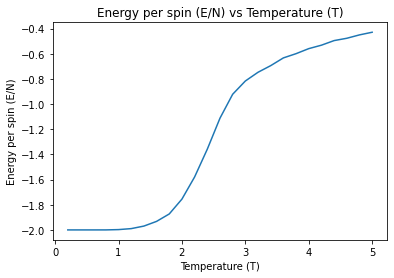

In [3]:
# do the plots
fig, ax = plt.subplots()
ax.plot(temps, energy_per_spin)
ax.set_xlabel("Temperature (T)")
ax.set_ylabel("Energy per spin (E/N)")
ax.set_title("Energy per spin (E/N) vs Temperature (T)")
fig.show()
# fig.savefig("energy_per_spin")
fig.savefig("energy_per_spin_10x10")

/var/folders/85/zd91wmvn09956_q0gy77y3080000gp/T/ipykernel_43994/4164975783.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


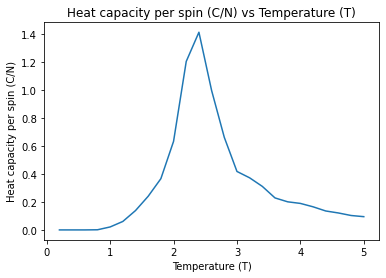

In [4]:
fig, ax = plt.subplots()
ax.plot(temps, C_v_per_spin)
ax.set_xlabel("Temperature (T)")
ax.set_ylabel("Heat capacity per spin (C/N)")
ax.set_title("Heat capacity per spin (C/N) vs Temperature (T)")
fig.show()
# fig.savefig("c_v_per_spin")
fig.savefig("c_v_per_spin_10x10")